In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
gbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin1_all.npz')
pbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin1_all.npz')

gbin2 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin2_all.npz')
pbin2 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin2_all.npz')

gbin3 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin3_all.npz')
pbin3 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin3_all.npz')

gbin4 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin4_all.npz')
pbin4 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin4_all.npz')

gbin5 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin5_all.npz')
pbin5 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin5_all.npz')

gbin6 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin6_all.npz')
pbin6 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin6_all.npz')

In [3]:
Ebins = 1
gim = gbin1['image'][:]
pim = pbin1['image'][:]
#gim = torch.tensor(gim).float() 
#pim = torch.tensor(gim).float() 
gim_label = torch.zeros([len(gim)])
pim_label = torch.ones([len(pim)]) 
classes = {0:'gamma',1:'proton'}

In [4]:
train_images = np.vstack((gim[:int(len(gim)*0.75)],pim[:int(len(pim)*0.75)]))
test_images  = np.vstack((gim[int(len(gim)*0.75):],pim[int(len(pim)*0.75):]))
train_labels = np.hstack((gim_label[:int(len(gim)*0.75)],pim_label[:int(len(pim)*0.75)]))
test_labels  = np.hstack((gim_label[int(len(gim)*0.75):],pim_label[int(len(pim)*0.75):]))

In [5]:
train_images = torch.tensor(train_images).float()
train_labels = torch.tensor(train_labels).float()
test_images  = torch.tensor(test_images).float()
test_labels  = torch.tensor(test_labels).float()

In [6]:
train_sets = ([(train_images[i],train_labels[i])for i in range(len(train_labels))])
test_sets = ([(test_images[i],test_labels[i])for i in range(len(test_labels))])

In [7]:
trainloader = torch.utils.data.DataLoader(train_sets, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_sets, batch_size=4, shuffle=True, num_workers=2)

In [8]:
print('# of gamma images : {}, # of proton images : {}'.format(len(gim),len(pim)))
print('# of Train : {}, # of Test : {}'.format(len(train_sets),len(test_sets)))

# of gamma images : 12974, # of proton images : 6230
# of Train : 14402, # of Test : 4802


In [9]:
dataloader = {'train':trainloader, 'valid':testloader}

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3)
        self.batch1 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)    
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*7*7, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*7*7)
        x = torch.sigmoid(self.fc1(x))
        return x

In [11]:
net = Net()
net = net.cuda()

In [13]:
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
#optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
def train_model(model, dataloader, criterion, optimizer, scheduler, Ebins, num_epochs=1):
    batchsize = 4
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train':[],'valid':[]}
    accuracy = {'train':[],'valid':[]}
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects= 0
            ep_running_loss = 0.0
            ep_running_corrects = 0
            
            for i, data in enumerate(dataloader[phase]):
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                #inputs = Variable(inputs)
                #labels = Variable(labels)
                if phase=='train':
                    optimizer.zero_grad()
                outputs = model(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs>0.5
                loss = criterion(outputs, labels.view(-1,1).float())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data
                ep_running_loss += loss.data
                target = labels.view(-1,1)>0.5
                running_corrects += torch.sum(preds==target)
                ep_running_corrects += torch.sum(preds==target)
                if i%100==99:

                    #writer.add_scalars('loss','train':running_loss/100,)
                    
                    writer.add_scalar('{} loss'.format(phase),
                                     running_loss/100,
                                     epoch*len(dataloader[phase])+i)
                    writer.add_scalar('{} Accuracy'.format(phase),
                                     float(running_corrects)/(100.0*batchsize),
                                     epoch*len(dataloader[phase])+i)
                    
                    writer.add_figure('predictions vs actuals, {}'.format(phase),
                                     plot_classes_preds(model, inputs, labels),
                                     global_step=epoch*len(dataloader[phase])+i)
                    running_loss = 0.0
                    running_corrects = 0

            writer.close()
            epoch_loss = ep_running_loss/(len(dataloader[phase])*batchsize)
            epoch_acc = float(ep_running_corrects)/(len(dataloader[phase])*batchsize)
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            print('{} Loss: {:.4f}, Acc : {:.4f}'.format( phase, epoch_loss, epoch_acc))    
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Acc: {:4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    return model,losses,accuracy    

In [15]:
def plottingLossAcc(losses,accuracy,Eb):
  # plotting losses, and accuracy
    plt.plot(range(1,len(losses['train'])+1),losses['train'], 'r',label='train')
    plt.plot(range(1,len(losses['valid'])+1),losses['valid'], 'b',label='test')
    plt.title('Losses B={}'.format( Eb))
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend()
    plt.savefig("plots/300_50000_m2.7/4filter/loss_B{}.png".format(Eb))
    plt.show()

    plt.plot(range(1,len(accuracy['train'])+1), accuracy['train'], 'r', label='train')
    plt.plot(range(1,len(accuracy['valid'])+1), accuracy['valid'], 'b', label='test')
    plt.title('Accuracy B={}'.format(Eb))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig("plots/300_50000_m2.7/4filter/accuracy_B{}.png".format(Eb))
    plt.show()

In [16]:
def test(testloader):
    correct = 0
    total = 0
    y_score = np.array([])
    y = np.array([])
    test_losses = []
    for data in testloader:
        images, labels = data
        labels = labels.cuda()
        labels = labels.view(-1,1)
        outputs = net(Variable(images.cuda()))
        #outputs = net(Variable(images))
        preds = outputs>0.5     
        loss = criterion(outputs, labels.float().cuda())
        #loss = criterion(outputs, labels.long())
        y_score = np.append(y_score,outputs.data.cpu().detach().numpy())
        y = np.append(y,labels.cpu().numpy())
        test_losses.append(loss.data/16.0)
        total += labels.size(0)
        target = labels.view(-1,1)>0.5
        correct += torch.sum(preds==target)
    return y, y_score, correct, total,  test_losses

In [17]:
def roc(y,y_score,correct,total,Eb):
    #ny = []
    #for i in y:
    #    if i == 0: ny.append([1,0])
    #    else : ny.append([0,1])
    ny = y
    fpr,tpr, _  = roc_curve(np.array(ny).ravel(),y_score.ravel())
    roc_auc = auc(fpr,tpr)
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0,1.0],title='ROC curve B={}'.format(Eb))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    fig.savefig("plots/300_50000_m2.7/4filter/roc_B{}.png".format(Eb))
    plt.show()
    print('Accuracy of the network on the {} test images: {} %'.format(len(testloader),100 * correct / total))


In [18]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [19]:
def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor= torch.max(output,1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [20]:
def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1,4,idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
        classes[preds[idx]],
               probs[idx]*100.0,
               classes[int(labels[idx])]),
                    color=('green' if preds[idx]==labels[idx].long() else "red"))
    return fig

In [21]:
'''
writer = SummaryWriter('runs/bin1')
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0])
matplotlib_imshow(img_grid)
writer.add_image('test_images', img_grid)
writer.add_graph(net, images)
writer.close()
'''

"\nwriter = SummaryWriter('runs/bin1')\ndataiter = iter(trainloader)\nimages, labels = dataiter.next()\nimg_grid = torchvision.utils.make_grid(images[0])\nmatplotlib_imshow(img_grid)\nwriter.add_image('test_images', img_grid)\nwriter.add_graph(net, images)\nwriter.close()\n"

In [22]:
from datetime import datetime
now = datetime.now()
logdir = "runs/bin{}/".format(Ebins) + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)
net,losses,accuracy = train_model(net, dataloader, criterion, optimizer, exp_lr_scheduler, Ebins,16)

Epoch 0/15
----------


/usr/local/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1070, Acc : 0.8091
valid Loss: 0.1519, Acc : 0.7057
Epoch 1/15
----------
train Loss: 0.0749, Acc : 0.8807
valid Loss: 0.1192, Acc : 0.8297
Epoch 2/15
----------
train Loss: 0.0623, Acc : 0.9083
valid Loss: 0.0890, Acc : 0.8653
Epoch 3/15
----------
train Loss: 0.0556, Acc : 0.9195
valid Loss: 0.0801, Acc : 0.8891
Epoch 4/15
----------
train Loss: 0.0525, Acc : 0.9233
valid Loss: 0.1034, Acc : 0.8953
Epoch 5/15
----------
train Loss: 0.0491, Acc : 0.9308
valid Loss: 0.0947, Acc : 0.8605
Epoch 6/15
----------
train Loss: 0.0441, Acc : 0.9373
valid Loss: 0.0744, Acc : 0.8957
Epoch 7/15
----------
train Loss: 0.0430, Acc : 0.9397
valid Loss: 0.0694, Acc : 0.9147
Epoch 8/15
----------
train Loss: 0.0420, Acc : 0.9404
valid Loss: 0.0872, Acc : 0.9053
Epoch 9/15
----------
train Loss: 0.0423, Acc : 0.9412
valid Loss: 0.1310, Acc : 0.8528
Epoch 10/15
----------
train Loss: 0.0418, Acc : 0.9406
valid Loss: 0.0751, Acc : 0.9259
Epoch 11/15
----------
train Loss: 0.0411, Acc : 0.94

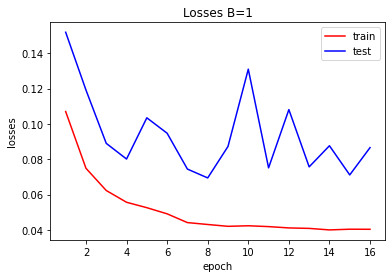

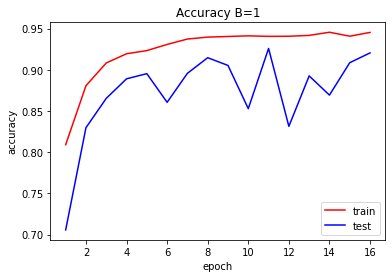

In [23]:
plottingLossAcc(losses,accuracy, Eb=Ebins)

In [24]:
y,y_score,correct,total,test_losses = test(testloader)

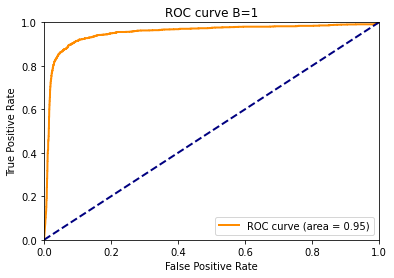

Accuracy of the network on the 1201 test images: 92 %


In [25]:
roc(y,y_score,correct,total,Ebins)